In [ ]:
import comet_ml
# TODO: ENTER YOUR API KEY HERE!!
COMET_API_KEY = ""

In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
from tqdm import tqdm

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics
import seaborn as sns
import random
from torch.utils.data import DataLoader, TensorDataset

# To display YouTube videos
from IPython.display import YouTubeVideo

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', device)

# MIT introduction to deep learning package
import mitdeeplearning as mdl


# Assert that the Comet API key is available
assert COMET_API_KEY, "Comet API key is missing!"

# Set the directory for Comet's Git integration
os.environ['COMET_GIT_DIRECTORY'] = ''

Device available now: cpu


In [6]:
# start a first comet experiment for the first part of the lab
comet_ml.init(project_name="6S191lab2_part1_NN")
comet_model_1 = comet_ml.Experiment()

COMET WARNING: comet_ml.init() is deprecated and will be removed soon. Please use comet_ml.login()
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: tensorflow, sklearn, torch, keras.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/chuawz09082/6s191lab2-part1-nn/1aed8bb15ce74d68a2103e12343f7945



In [7]:
# Load and preprocess the MNIST datasets
transform = torchvision.transforms.ToTensor()  # Transform images to tensors

# Download and transform the MNIST training data
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

# Download and transform the MNIST validation data
validation_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

{'web': 'https://www.comet.com/api/image/download?imageId=18b4f83861c24bf49f05d2e1e9ad48c7&experimentKey=1aed8bb15ce74d68a2103e12343f7945',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=18b4f83861c24bf49f05d2e1e9ad48c7&experimentKey=1aed8bb15ce74d68a2103e12343f7945',
 'imageId': '18b4f83861c24bf49f05d2e1e9ad48c7'}

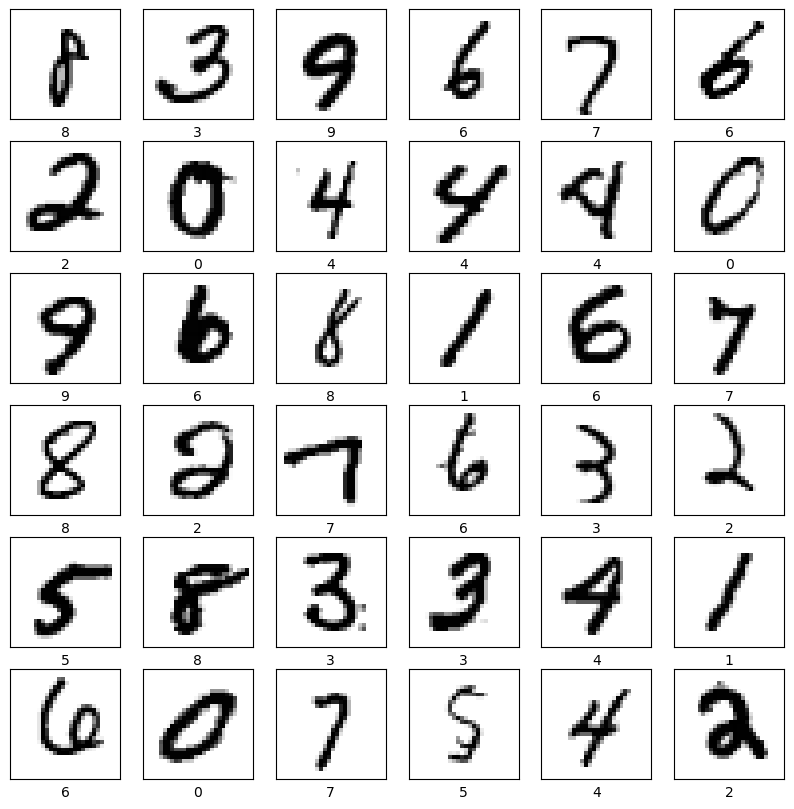

In [9]:
# Visualize random samples from the training dataset
plt.figure(figsize=(10,10))
random_inds = np.random.choice(60000, 36)  # Select 36 random indices
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(training_data.data[image_ind]), cmap=plt.cm.binary)
    plt.xlabel(training_data.targets[image_ind].item())
# Log the figure to Comet
comet_model_1.log_figure(figure=plt)

In [10]:
# Normalize the dataset to range [0, 1]
X_train = training_data.data / 255.0
Y_train = training_data.targets
X_test = validation_data.data / 255.0
Y_test = validation_data.targets

# Prepare datasets and dataloaders
dataset_train = TensorDataset(X_train, Y_train)
dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True)
dataset_test = TensorDataset(X_test, Y_test)
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=False)


In [11]:
# Define a fully connected model
class build_fc_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # First fully connected layer
        self.fc2 = nn.Linear(hidden_dim, output_dim)  # Second fully connected layer
        self.relu = nn.ReLU()  # ReLU activation function
    
    def forward(self, x):
        x = x.reshape(x.shape[0], x.shape[1]*x.shape[2])  # Flatten the input
        x = self.relu(self.fc1(x))  # Apply first layer and ReLU
        x = self.fc2(x)  # Apply second layer
        return x

# Set hyperparameters for the fully connected model
learning_rate = 0.1
epochs = 80

# Initialize the fully connected model, loss function, and optimizer
model = build_fc_model(X_train.shape[1]*X_train.shape[2], 128, 10)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
model.train()

# Train the fully connected model
for epoch in range(epochs):
    training_losses = []
    for batch in dataloader_train:
        x, y = batch[0].to(device), batch[1].to(device)  # Move data to the appropriate device
        optimizer.zero_grad()
        pred = model(x)  # Forward pass
        loss = criterion(pred, y)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters
        training_losses.append(loss.item())
    if (epoch+1) % 10 == 0:  # Print loss every 10 epochs
        print("Finished epoch", epoch+1, ", training loss: ", np.mean(training_losses))

Finished epoch 10 , training loss:  0.061739864694113446
Finished epoch 20 , training loss:  0.027602021782986645
Finished epoch 30 , training loss:  0.014349254610231404
Finished epoch 40 , training loss:  0.007947828429728758
Finished epoch 50 , training loss:  0.004926221341446741
Finished epoch 60 , training loss:  0.003481910349062107
Finished epoch 70 , training loss:  0.0026391306646144155
Finished epoch 80 , training loss:  0.0020859885621701863


In [12]:
# Evaluate the model on the training set
with torch.no_grad():
    num_correct = 0
    total_size = 0
    model.eval()
    for batch in dataloader_train:
        x, y = batch[0].to(device), batch[1].to(device)
        pred = model(x)
        pred_label = torch.argmax(pred, dim=-1)  # Get predicted labels
        num_correct += (pred_label == y).sum().item()
        total_size += x.shape[0]
    print("Final accuracy on Training Set: ", num_correct/total_size)

# Evaluate the model on the test set
with torch.no_grad():
    num_correct = 0
    total_size = 0
    model.eval()
    for batch in dataloader_test:
        x, y = batch[0].to(device), batch[1].to(device)
        pred = model(x)
        pred_label = torch.argmax(pred, dim=-1)
        num_correct += (pred_label == y).sum().item()
        total_size += x.shape[0]
    print("Final accuracy on Testing Set: ", num_correct/total_size)

Final accuracy on Training Set:  0.9999833333333333
Final accuracy on Testing Set:  0.9812


In [13]:
# Define a Convolutional Neural Network (CNN)
class CNN(nn.Module):
    def __init__(self, in_chan, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_chan, out_channels=24, kernel_size=3, stride=1, padding=0)  # First conv layer
        self.bn1 = nn.BatchNorm2d(24)  # Batch normalization for the first conv layer

        self.conv2 = nn.Conv2d(in_channels=24, out_channels=36, kernel_size=3, stride=1, padding=0)  # Second conv layer
        self.bn2 = nn.BatchNorm2d(36)  # Batch normalization for the second conv layer

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        self.fc1 = nn.Linear(36*5*5, 128)  # First fully connected layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)  # Output layer
    
    def forward(self, x):
        x = self.pool(self.bn1(self.conv1(x)))  # Apply conv1, batch norm, and pooling
        x = self.pool(self.bn2(self.conv2(x)))  # Apply conv2, batch norm, and pooling
        x = x.reshape(x.shape[0], -1)  # Flatten the output
        x = self.relu(self.fc1(x))  # Fully connected layer 1 with ReLU
        x = self.fc2(x)  # Fully connected output layer
        return x

# Initialize the CNN model, optimizer, and loss function
CNN_model = CNN(1, 10).to(device)
epochs = 10
learning_rate = 0.01
optimizer = optim.Adam(CNN_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
CNN_model.train()

# Train the CNN model
for epoch in range(epochs):
    training_losses = []
    for batch in dataloader_train:
        x, y = batch[0].to(device), batch[1].to(device)
        x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])  # Add channel dimension
        optimizer.zero_grad()
        pred = CNN_model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())
    print("Finished epoch: ", epoch+1, ", training loss: ", np.mean(training_losses))

Finished epoch:  1 , training loss:  0.15873038162117892
Finished epoch:  2 , training loss:  0.06649516002080941
Finished epoch:  3 , training loss:  0.0535509156713288
Finished epoch:  4 , training loss:  0.04754182116174053
Finished epoch:  5 , training loss:  0.048535747575089716
Finished epoch:  6 , training loss:  0.043887926228620276
Finished epoch:  7 , training loss:  0.04192310417045186
Finished epoch:  8 , training loss:  0.040997437289197844
Finished epoch:  9 , training loss:  0.04025344379015669
Finished epoch:  10 , training loss:  0.034963118762018394


In [14]:
# Evaluate CNN model on the training set
with torch.no_grad():
    model.eval()
    num_correct = 0
    total_size = 0
    for batch in dataloader_train:
        x, y = batch[0].to(device), batch[1].to(device)
        pred = model(x)
        pred_label = torch.argmax(pred, dim=-1)
        num_correct += (pred_label == y).sum().item()
        total_size += x.shape[0]
    print("Training accuracy: ", num_correct/total_size)

# Evaluate CNN model on the test set
with torch.no_grad():
    model.eval()
    num_correct = 0
    total_size = 0
    Y_pred = []
    for batch in dataloader_test:
        x, y = batch[0].to(device), batch[1].to(device)
        pred = model(x)
        pred_label = torch.argmax(pred, dim=-1)
        Y_pred.append(pred_label)
        num_correct += (pred_label == y).sum().item()
        total_size += x.shape[0]
    print("Testing accuracy: ", num_correct/total_size)
    Y_pred = torch.cat(Y_pred)

Training accuracy:  0.9999833333333333
Testing accuracy:  0.9812


{'web': 'https://www.comet.com/api/image/download?imageId=26cbcc56b9334e80935f9cafae641feb&experimentKey=1aed8bb15ce74d68a2103e12343f7945',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=26cbcc56b9334e80935f9cafae641feb&experimentKey=1aed8bb15ce74d68a2103e12343f7945',
 'imageId': '26cbcc56b9334e80935f9cafae641feb'}

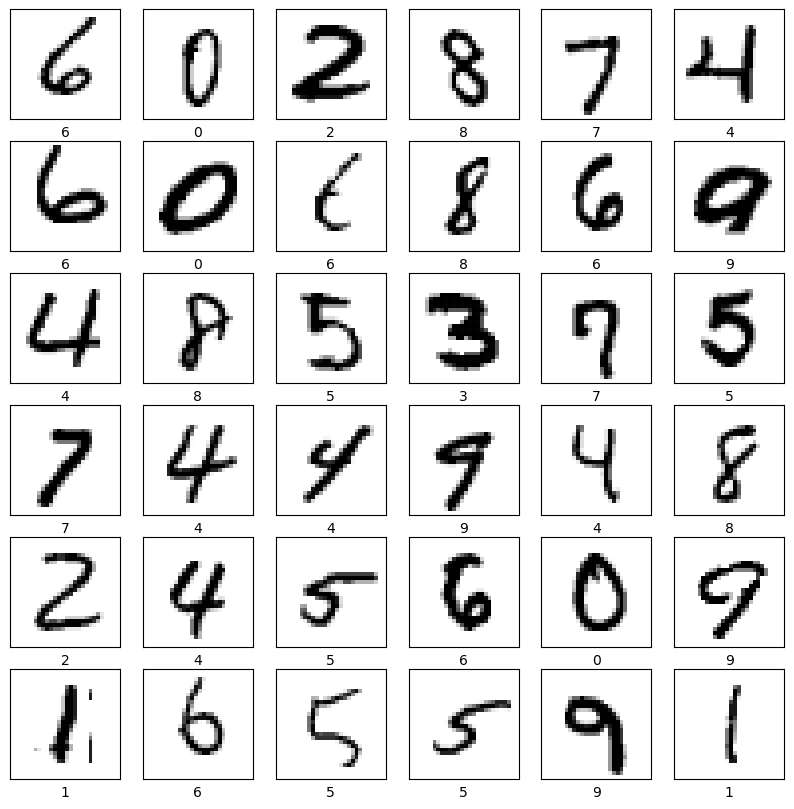

In [15]:
# Visualize predictions for random test images
plt.figure(figsize=(10,10))
random_inds = np.random.choice(10000, 36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(X_test[image_ind]), cmap=plt.cm.binary)
    plt.xlabel(Y_pred[image_ind].item())
# Log predictions figure to Comet
comet_model_1.log_figure(figure=plt)